## Predicting Prices of Bulldozers using Machine Learning

This notebook will be used to explore a machine learning project with the goal of predicting the sale prices of bulldozers. Since we are trying to predict prices, which are continuous numeric values, this is a regression type problem. The data is originally from the Kaggle Blue Book for Bulldozers competition.

### Problem Definition

The goal of the project is to predict the sale price of a particular piece of heavy equiment at auction based on its usage, equipment type, and configuration. In a statement:

Given its characteristics, to what extent can we predict the future sale price of a bulldozer?

### Datasets

It seems there is a time element from looking at the datasets. This means we are also working on a time series problem. We have been given historical sales data of bulldozers and they have already been split into three different data sets.

- Train.csv is the training set, which contains data through the end of 2011

- Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012

- Test.csv is the test set, which contains data from May 1, 2012 - November 2012

### Importing Tools and Exploring Data

In [1]:
# Importing data analysis tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Importing combined training and validation set
df = pd.read_csv("TrainAndValid.csv", low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

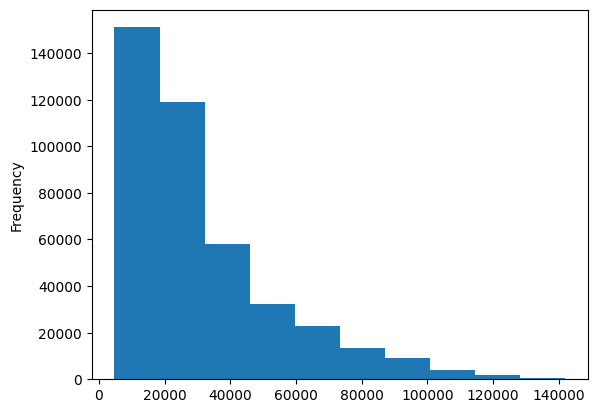

In [3]:
df["SalePrice"].plot.hist();

Most of the sale prices seem to be around $20,000 +/- $10,000

In [4]:
df["saledate"][:10]

0    11/16/2006 0:00
1     3/26/2004 0:00
2     2/26/2004 0:00
3     5/19/2011 0:00
4     7/23/2009 0:00
5    12/18/2008 0:00
6     8/26/2004 0:00
7    11/17/2005 0:00
8     8/27/2009 0:00
9      8/9/2007 0:00
Name: saledate, dtype: object

These dates don't really happen to be in a desirable form as their dtype is an object, so will parse them to enrich their date and time component. We will import the data again to override our previous data frame.

In [5]:
df = pd.read_csv("TrainAndValid.csv", low_memory=False, parse_dates=["saledate"])
df["saledate"][:10]

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
5   2008-12-18
6   2004-08-26
7   2005-11-17
8   2009-08-27
9   2007-08-09
Name: saledate, dtype: datetime64[ns]

The time series element of the data is now in a different format and is recognized as dates.

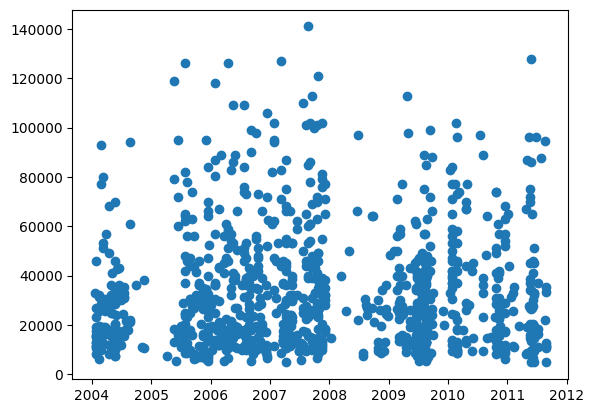

In [6]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000]);

Sales seem to be fairly consistent throughout, other than a few patches at the end of 2004 and beginning of 2005, and during 2008.

In [7]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The data is mixed all over and is not set in an orderly fashion. Since this project has a time series element to it, it makes sense to sort the data by its date.

In [8]:
df = df.sort_values(by=["saledate"], ascending=True)
df.saledate.head(10)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
Name: saledate, dtype: datetime64[ns]

In [9]:
# Making a copy of original data frame with parsing
df_copy = df.copy()

We will manipulate some data with the copy, and still have the original in case we need to revert back to it. We will now add date time parameters for our saledate column to extract as much useful information as possible.

In [10]:
df_copy["saleYear"] = df_copy.saledate.dt.year
df_copy["saleMonth"] = df_copy.saledate.dt.month
df_copy["saleDay"] = df_copy.saledate.dt.day
df_copy["saleDayofweek"] = df_copy.saledate.dt.dayofweek
df_copy["saleDayofyear"] = df_copy.saledate.dt.dayofyear

# Dropping original saledate parameter
df_copy.drop("saledate", axis = 1, inplace=True)

df_copy.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,A62,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,D3B,...,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,1,31


In [11]:
df_copy["state"].value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Iowa               1336
Montana            1336
Oklahoma           1326
Nebraska            866
West Virginia   

States like Florida and Texas have the most sales, while the capital Washington DC and the US territory Puerto Rico happen to have the least.

Since a lot of our data isn't numeric, before we model we have to covert strings into numbers by using pandas categories.

In [12]:
# Finding columns with strings and turning them into categories
for label, content in df_copy.items():
    if pd.api.types.is_string_dtype(content):
        df_copy[label] = content.astype("category").cat.as_ordered()

df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [13]:
df_copy.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

Our object type data can now be converted in the form of numbers after turning them into categories. However, before we can start to model, we need to tackle another issue of the missing data. From the output of df_copy.info() we can that the non-null values seem to differ for most columns. This suggests that there are missing values from our data set.

In [14]:
# Percentage of missing data in each column 
(df_copy.isnull().sum()/len(df_copy)) * 100

SalesID                      0.000000
SalePrice                    0.000000
MachineID                    0.000000
ModelID                      0.000000
datasource                   0.000000
auctioneerID                 4.879113
YearMade                     0.000000
MachineHoursCurrentMeter    64.258610
UsageBand                   82.149174
fiModelDesc                  0.000000
fiBaseModel                  0.000000
fiSecondaryDesc             34.099269
fiModelSeries               85.784520
fiModelDescriptor           81.871490
ProductSize                 52.485110
fiProductClassDesc           0.000000
state                        0.000000
ProductGroup                 0.000000
ProductGroupDesc             0.000000
Drive_System                74.051970
Enclosure                    0.080931
Forks                       52.092087
Pad_Type                    80.349796
Ride_Control                62.992794
Stick                       80.349796
Transmission                54.444412
Turbocharged

The majority of columns have missing data to an extent, while certain columns have almost 94% of their rows as null. This means we cannot just simply remove the rows with null values as we would lose most, if not all of our dataset. A better option would be to fill the missing information. We will have to fill numeric and categorical columns seperately.

In [15]:
# Checking which float or integer type columns have nulls
for label, content in df_copy.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).any():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [16]:
# Filling missings rows
for label, content in df_copy.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).any():
            # adding binary column to indicate whether value was missing or not
            df_copy[label + "is_missing"] = pd.isnull(content)
            # filling missing values
            df_copy[label] = content.fillna(content.median())

Here, we are using the median of each column to fill the missing rows. Since we are dealing with a large dataset, median will tend to be more reliable than the mean since we may be subject to big outliers.

In [17]:
df_copy.auctioneerIDis_missing.value_counts()

False    392562
True      20136
Name: auctioneerIDis_missing, dtype: int64

20136 rows of the auctioneerID column were filled

In [18]:
df_copy.MachineHoursCurrentMeteris_missing.value_counts()

True     265194
False    147504
Name: MachineHoursCurrentMeteris_missing, dtype: int64

147504 rows of the MachineHoursCurrentMeter were filled

In [19]:
# Turn all categorical data into numbers and fill nulls
for label, content in df_copy.items():
    if not pd.api.types.is_numeric_dtype(content):
        # adding binary column to indicate whether value was missing or not
        df_copy[label + "is_missing"] = pd.isnull(content)
        # turn categories into numbers 
        df_copy[label] = pd.Categorical(content).codes+1
        # +1 is added since missing values are assigned as -1, so adding 1 turns them into 0

In [20]:
df_copy.isnull().sum()

SalesID                        0
SalePrice                      0
MachineID                      0
ModelID                        0
datasource                     0
                              ..
Backhoe_Mountingis_missing     0
Blade_Typeis_missing           0
Travel_Controlsis_missing      0
Differential_Typeis_missing    0
Steering_Controlsis_missing    0
Length: 103, dtype: int64

Now all of the data is numeric and there are no more missing values.

### Modeling

The data we had originally imported was combined for both training and validation. We will now split them into different sets. The training set was defined as all data through the end of 2011. The validation set was defined as data from January 1st to April 30th of 2012. So we will set the validation set as all data from 2012, and the training set as all remaining data.

In [21]:
df_val = df_copy[df_copy.saleYear == 2012]
df_train = df_copy[df_copy.saleYear != 2012]
len(df_train), len(df_val)

(401125, 11573)

In [51]:
# Split data into X & y
df_train_x = df_train.drop("SalePrice", axis=1)
X_train = df_train_x.values
y_train = df_train["SalePrice"]

df_val_x = df_val.drop("SalePrice", axis =1)
X_val = df_val_x.values
y_val = df_val["SalePrice"]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((401125, 102), (401125,), (11573, 102), (11573,))

In [47]:
# Creating an evaluation function for RMSLE
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Creating function to evaluate models on different levels
def diff_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
    "Validation MAE": mean_absolute_error(y_val, val_preds),
    "Training MSE": mean_squared_error(y_train, train_preds),
    "Validation MSE": mean_squared_error(y_val, val_preds),
    "Training R^2": r2_score(y_train, train_preds),
    "Validation R^2": r2_score(y_val, val_preds)}
    return scores


In [48]:
# fitting a trained model
from xgboost import XGBRegressor
model = XGBRegressor(random_state=66)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=66, ...)

In [52]:
diff_scores(model)

{'Training MAE': 4958.514079039855,
 'Validation MAE': 6449.994007628693,
 'Training MSE': 55004484.80059099,
 'Validation MSE': 90753332.58400092,
 'Training R^2': 0.8963543293163568,
 'Validation R^2': 0.8678745415617466}

We get the above scores for three different evaluation metrics based on training data and validation data. Now that we have a trained model, we can make predictions on the test data. Our model has been trained on all data before 2012 and the test data is from May - November 2012. As a result, we are trying to make predictions on data the model has never seen before, so let's see how it performs.

In [65]:
df_test = pd.read_csv("Test.csv", parse_dates=["saledate"])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


As we have just imported the test data, it is not in the same format as our most updated dataset- which our model had been trained on. So, all the changes that were made to the original training and validation dataset have to also be applied to the test data. Let's create a function to preprocess the data.

In [67]:
def preprocess_data(df):
    # add datetime parameters for saledate
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayofweek"] = df.saledate.dt.dayofweek
    df["saleDayofyear"] = df.saledate.dt.dayofyear

    # drop original saledate parameter
    df.drop("saledate", axis = 1, inplace=True)

    # fill numeric columns with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).any():
                # adding binary column to indicate whether value was missing or not
                df[label + "is_missing"] = pd.isnull(content)
                # filling missing values
                df[label] = content.fillna(content.median())

        # turn categorical data into numbers and fill nulls
        if not pd.api.types.is_numeric_dtype(content):
            # adding binary column to indicate whether value was missing or not
            df[label + "is_missing"] = pd.isnull(content)
            # turn categories into numbers 
            df[label] = pd.Categorical(content).codes+1
            # +1 is added since missing values are assigned as -1, so adding 1 turns them into 0

    return df

In [68]:
df_test = preprocess_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Widthis_missing,Stick_Lengthis_missing,Thumbis_missing,Pattern_Changeris_missing,Grouser_Typeis_missing,Backhoe_Mountingis_missing,Blade_Typeis_missing,Travel_Controlsis_missing,Differential_Typeis_missing,Steering_Controlsis_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [69]:
df_test.shape, X_train.shape

((12457, 101), (401125, 102))

There is one less column in the test data compared to the train data. Let's check what is missing.

In [70]:
set(df_train_x.columns) - set(df_test.columns)

{'auctioneerIDis_missing'}

This means that in the test data, auctioneerID did not have any missing values, as a result the "missing" column for it is missing. In this case, we can just manually add this column and fill it with False all the way down, since none of the values were missing.

In [71]:
df_test["auctioneerIDis_missing"] = False
df_test_values = df_test.values

In [72]:
# Making predicitons on the test data
test_predictions = model.predict(df_test_values)

Let's now create a separate data frame containing the SalesID and the predicted SalesPrice.

In [73]:
df_predictions = pd.DataFrame()
df_predictions["SalesID"] = df_test["SalesID"]
df_predictions["SalesPrice"] = test_predictions
df_predictions

,SalesID,SalesPrice
0,1227829,16885.878906
1,1227844,6368.036621
2,1227847,55625.125000
3,1227848,72309.734375
4,1227863,49789.121094
...,...,...
12452,6643171,62529.234375
12453,6643173,10754.685547
12454,6643184,10839.473633
12455,6643186,15717.359375


### Feature Importance

The model has learned patterns in the data and has made predictions, however, can we find out which variables were the most influential in driving the predictions?

In [74]:
feature_imp = pd.DataFrame(zip(df_test.columns, list(model.feature_importances_)), 
columns= ["Features", "Feature Importance"])
feature_imp = feature_imp.sort_values(by= ["Feature Importance"], ascending = False)
top_features = feature_imp[:20]

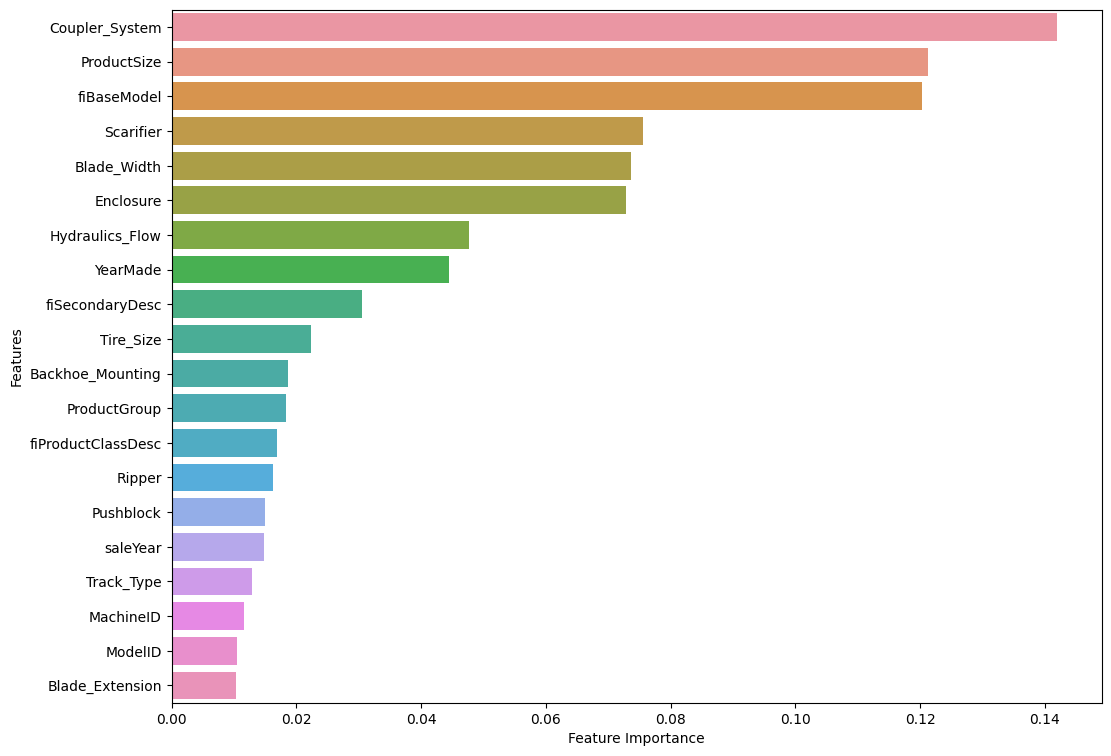

In [75]:
feature_fig = plt.figure(figsize= (12, 9))
ax = sns.barplot(data=top_features, x="Feature Importance", y="Features")

In [77]:
int(sum(model.feature_importances_))

1

The feature importances for all 102 columns add up to 1. In the figure above, we can see a visualization of the top 20 most influential features for the model prediction. The machinery's coupler system is the most important feature, culminating around 15% of the total sum of feature importances. ProductSize and fiBaseModel are also not far behind with over 12% of total importance each.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=795adfac-de29-42ee-b547-53c1d0160c04' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>